# Proyecto 3 Minería de Datos
## Integrantes:
- Carlos Valladares, 221164
- Julio Lemus, 22461
- Hugo Rivas, 22500
- Alexis Mesias, 22562

### Carga de datos y unión de tablas

In [7]:
import pandas as pd

orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")

# Convertir fechas a formato datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Calcular el tiempo de entrega en días
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Unir las tablas necesarias
df = orders.merge(order_items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(reviews, on='order_id', how='left') \
           .merge(customers, on='customer_id', how='left')

# Mantener solo las columnas clave
df = df[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time',
         'price', 'freight_value', 'review_score', 'product_category_name',
         'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]

print("df creado correctamente con shape:", df.shape)


df creado correctamente con shape: (114092, 12)


### Análisis Exploratorio de Datos (EDA)

       delivery_time          price  freight_value   review_score  \
count  110839.000000  113314.000000  113314.000000  113131.000000   
mean       12.012414     120.478701      19.979428       4.016998   
std         9.445470     183.279678      15.783227       1.400074   
min         0.000000       0.850000       0.000000       1.000000   
25%         6.000000      39.900000      13.080000       4.000000   
50%        10.000000      74.900000      16.260000       5.000000   
75%        15.000000     134.900000      21.150000       5.000000   
max       209.000000    6735.000000     409.680000       5.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count     113296.000000      113296.000000      113296.000000   
mean        2091.915037          30.162495          16.584513   
std         3749.804597          16.151737          13.439206   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           

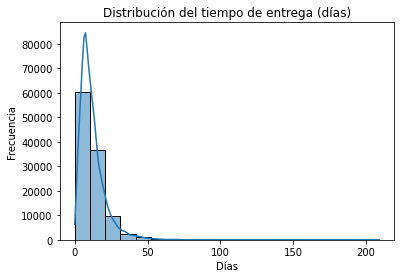

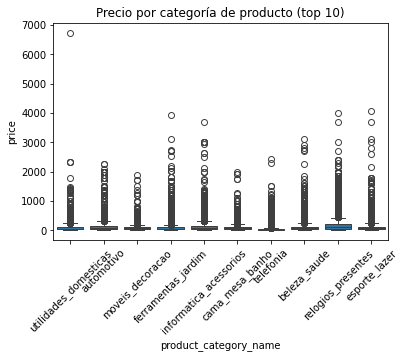

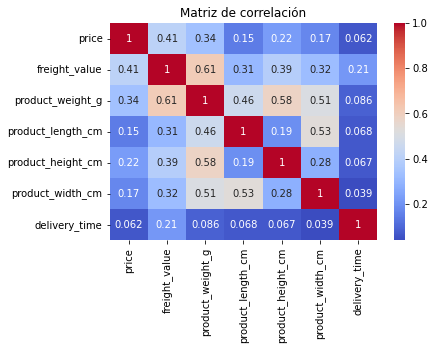

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen estadístico
print(df.describe())

# Histograma del tiempo de entrega
sns.histplot(df['delivery_time'].dropna(), bins=20, kde=True)
plt.title("Distribución del tiempo de entrega (días)")
plt.xlabel("Días")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot del precio por categoría
top_cats = df['product_category_name'].value_counts().head(10).index
sns.boxplot(data=df[df['product_category_name'].isin(top_cats)],
            x='product_category_name', y='price')
plt.xticks(rotation=45)
plt.title("Precio por categoría de producto (top 10)")
plt.show()

# Matriz de correlación
num_vars = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_time']
corr = df[num_vars].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

### Preprocesamiento del Dataset

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ======== 1. PREPROCESAMIENTO GENERAL ========
df_model = df.dropna(subset=[
    'price', 'delivery_time', 'review_score', 'product_category_name',
    'freight_value', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm'
]).copy()

# Codificación
le = LabelEncoder()
df_model['product_category_encoded'] = le.fit_transform(df_model['product_category_name'])
df_model['satisfaccion'] = df_model['review_score'].apply(lambda x: 1 if x >= 4 else 0)

features = ['price', 'freight_value', 'product_weight_g', 'product_length_cm',
            'product_height_cm', 'product_width_cm', 'product_category_encoded']

X = df_model[features]
y_reg = df_model['delivery_time']
y_clf = df_model['satisfaccion']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# ======== 2. REGRESIÓN ========
X_train_sample = X_train_reg.sample(3000, random_state=42)
y_train_sample = y_train_reg.loc[X_train_sample.index]

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

print("REGRESIÓN")
for name, model in models_reg.items():
    model.fit(X_train_sample, y_train_sample)
    y_pred = model.predict(X_test_reg)

    print(f"\n {name}")
    print("MAE:", round(mean_absolute_error(y_test_reg, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 2))
    print("R²:", round(r2_score(y_test_reg, y_pred), 4))

# ======== 3. CLASIFICACIÓN ========
X_train_clf_sample = X_train_clf.sample(5000, random_state=42)
y_train_clf_sample = y_train_clf.loc[X_train_clf_sample.index]

X_test_clf = X_test_clf.dropna()
y_test_clf = y_test_clf.loc[X_test_clf.index]

models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42)
}

print("\nCLASIFICACIÓN")
for name, model in models_clf.items():
    model.fit(X_train_clf_sample, y_train_clf_sample)
    y_pred = model.predict(X_test_clf)

    print(f"\n {name}")
    print("Accuracy:", round(accuracy_score(y_test_clf, y_pred), 4))
    print("Precision:", round(precision_score(y_test_clf, y_pred), 4))
    print("Recall:", round(recall_score(y_test_clf, y_pred), 4))
    print("F1-score:", round(f1_score(y_test_clf, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred))


REGRESIÓN

 Linear Regression
MAE: 6.01
RMSE: 8.94
R²: 0.0479

 Random Forest
MAE: 5.83
RMSE: 8.87
R²: 0.0624

CLASIFICACIÓN

 Logistic Regression
Accuracy: 0.7679
Precision: 0.7685
Recall: 0.999
F1-score: 0.8687
Confusion Matrix:
 [[    2  5019]
 [   16 16659]]

 Random Forest
Accuracy: 0.7464
Precision: 0.7781
Recall: 0.9373
F1-score: 0.8503
Confusion Matrix:
 [[  563  4458]
 [ 1045 15630]]


### Exportar el dataset preprocesado

In [13]:
df_model.to_csv("olist_dataset_modelado.csv", index=False)
print("Dataset exportado exitosamente como 'olist_dataset_modelado.csv'")

Dataset exportado exitosamente como 'olist_dataset_modelado.csv'


### MODELOS DE REGRESIÓN

Regresión Simple

Regresión Lineal Simple
Coeficiente (pendiente): 0.128269898043979
Intercepto: 9.404819025303238
MAE: 6.09
RMSE: 9.13
R²: 0.0464


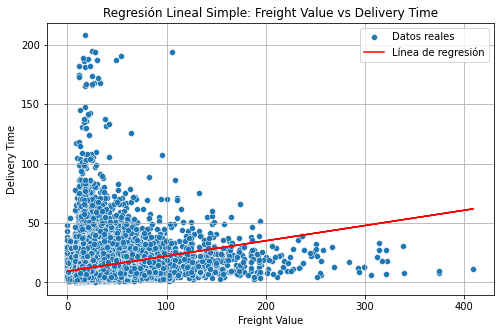

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos
x_simple = df_model[['freight_value']]
y_simple = df_model['delivery_time']

# Entrenamiento
model_simple = LinearRegression()
model_simple.fit(x_simple, y_simple)

# Predicción
y_pred_simple = model_simple.predict(x_simple)

# Métricas
print("Regresión Lineal Simple")
print("Coeficiente (pendiente):", model_simple.coef_[0])
print("Intercepto:", model_simple.intercept_)
print("MAE:", round(mean_absolute_error(y_simple, y_pred_simple), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_simple, y_pred_simple)), 2))  
print("R²:", round(r2_score(y_simple, y_pred_simple), 4))
plt.figure(figsize=(8,5))
sns.scatterplot(x=x_simple['freight_value'], y=y_simple, label='Datos reales')
plt.plot(x_simple, y_pred_simple, color='red', label='Línea de regresión')
plt.xlabel('Freight Value')
plt.ylabel('Delivery Time')
plt.title('Regresión Lineal Simple: Freight Value vs Delivery Time')
plt.legend()
plt.grid(True)
plt.show()

Aunque la línea de regresión sube un poco (es decir, hay una ligera relación positiva entre el costo de envío y el tiempo de entrega), la dispersión de los puntos es enorme. Eso quiere decir que el valor del transporte por sí solo no explica muy bien cuánto se va a tardar en llegar un pedido.
El R² es de apenas 0.046, o sea, la línea apenas explica el 4.6% del comportamiento real. En resumen, sí hay una tendencia, pero es tan débil que no podemos confiar mucho solo en este dato.

#### Ajuste de Parámetros

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

modelo_simple = LinearRegression()
scores_simple = cross_val_score(modelo_simple, x_simple, y_simple, scoring='neg_mean_squared_error', cv=5)

mse_simple = -scores_simple
rmse_simple = np.sqrt(mse_simple.mean())

print("RMSE promedio (Regresión Lineal Simple):", rmse_simple)


RMSE promedio (Regresión Lineal Simple): 9.131183943030653


Regresión múltiple

Regresión Lineal Múltiple
MAE: 6.05
RMSE: 9.11
R²: 0.0515


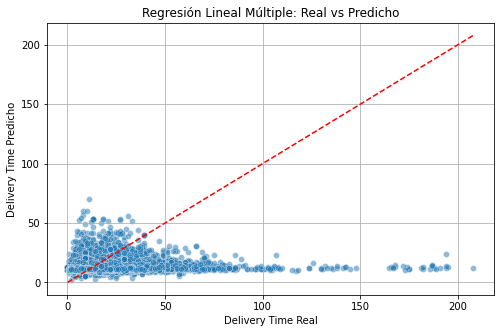

In [12]:
X_multi = df_model[['price', 'freight_value', 'product_weight_g',
                    'product_length_cm', 'product_height_cm',
                    'product_width_cm', 'product_category_encoded']]
y_multi = df_model['delivery_time']

# Modelo
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

# Predicción
y_pred_multi = model_multi.predict(X_multi)

# Métricas
print("Regresión Lineal Múltiple")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_multi), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_multi)), 2))
print("R²:", round(r2_score(y_multi, y_pred_multi), 4))
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_multi, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Regresión Lineal Múltiple: Real vs Predicho")
plt.grid(True)
plt.show()


Aquí ya usamos varias variables para predecir el tiempo de entrega, y aunque el modelo mejoró apenas un poco comparado con la regresión simple (el R2 subió a 0.0515, o sea, ahora explica el 5.1% del total), todavía le cuesta bastante predecir con precisión.  
La nube de puntos está bastante dispersa y muchos valores están lejos de la línea punteada ideal. En resumen, usar más variables sí ayudó pero no es suficiente. Probablemente hay factores fuera del dataset que están influyendo mucho más (como logística, zona de entrega, tráfico, etc).


### Ajuste de Parámetros

In [13]:
modelo_multiple = LinearRegression()
scores_multiple = cross_val_score(modelo_multiple, X_multi, y_multi, scoring='neg_mean_squared_error', cv=5)

# Convertimos a errores positivos y sacamos la media
mse_multiple = -scores_multiple
rmse_multiple = np.sqrt(mse_multiple.mean())

print("RMSE promedio (Regresión Lineal Múltiple):", rmse_multiple)


RMSE promedio (Regresión Lineal Múltiple): 9.107686165573913


Regresión polinomial


Regresión Polinomial (grado 2)
Coeficientes: [ 5.99063235e-03 -1.71525401e-06]
Intercepto: 11.328725049521395
MAE: 6.29
RMSE: 9.32
R²: 0.0057


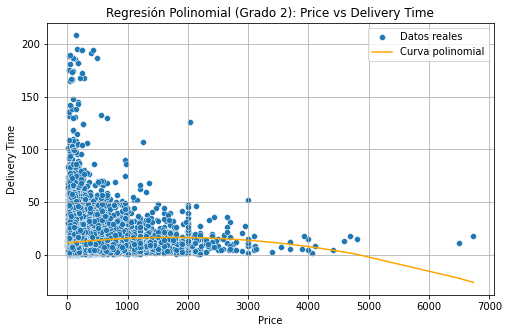

In [16]:
from sklearn.preprocessing import PolynomialFeatures

# Variable base
X_poly_base = df_model[['price']]
y_poly = df_model['delivery_time']

# Transformación polinomial de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_base)

# Modelo
model_poly = LinearRegression()
model_poly.fit(X_poly, y_poly)

# Predicción
y_pred_poly = model_poly.predict(X_poly)

# Métricas
print("Regresión Polinomial (grado 2)")
print("Coeficientes:", model_poly.coef_)
print("Intercepto:", model_poly.intercept_)
print("MAE:", round(mean_absolute_error(y_poly, y_pred_poly), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_poly, y_pred_poly)), 2))
print("R²:", round(r2_score(y_poly, y_pred_poly), 4))

plt.figure(figsize=(8,5))
sorted_idx = X_poly_base['price'].argsort()
x_sorted = X_poly_base['price'].iloc[sorted_idx]
y_sorted = y_pred_poly[sorted_idx]

sns.scatterplot(x=X_poly_base['price'], y=y_poly, label='Datos reales')
plt.plot(x_sorted, y_sorted, color='orange', label='Curva polinomial')
plt.xlabel('Price')
plt.ylabel('Delivery Time')
plt.title('Regresión Polinomial (Grado 2): Price vs Delivery Time')
plt.legend()
plt.grid(True)
plt.show()


Aquí intentamos ajustar una curva en lugar de una línea, para ver si el precio del producto se relaciona de forma no lineal con el tiempo de entrega. Visualmente la curva se ve más “ajustada” que una recta, pero la verdad es que el modelo sigue sin capturar bien la realidad.
El R² es bajísimo (0.0057), lo que quiere decir que la relación entre el precio del producto y el tiempo de entrega prácticamente no existe o no es útil para predecir.

Ajuste de Parámetros

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

X_poly = X_train_sample[['price']]
y_poly = y_train_sample

modelo_poli = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

scores_poli = cross_val_score(modelo_poli, X_poly, y_poly, scoring='neg_mean_squared_error', cv=5)

rmse_poli = np.sqrt(-scores_poli.mean())

print("RMSE promedio (Regresión Polinomial, grado 2):", round(rmse_poli, 2))


RMSE promedio (Regresión Polinomial, grado 2): 9.6


### árbol de decisión

Regresión con Árbol de Decisión
MAE: 1.46
RMSE: 3.81
R²: 0.8344


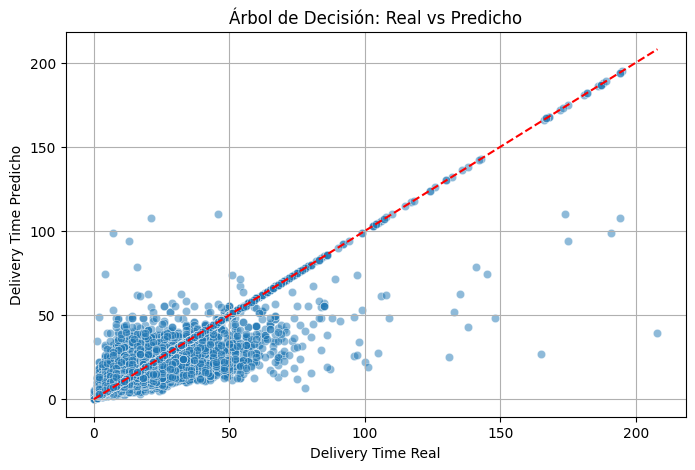

In [17]:
# Árbol de Decisión SIN split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_multi, y_multi)

# Predicción
y_pred_dt = dt_model.predict(X_multi)

# Métricas
print("Regresión con Árbol de Decisión")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_dt), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_dt)), 2))
print("R²:", round(r2_score(y_multi, y_pred_dt), 4))

# Gráfico Real vs Predicho
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_dt, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Árbol de Decisión: Real vs Predicho")
plt.grid(True)
plt.show()


En el caso del Árbol de Decisión, observamos una fuerte correspondencia visual entre los tiempos de entrega reales y predichos, donde la mayoría de los puntos se alinean bastante bien a la línea de referencia roja. El R cuadrado obtenido es de 0.8344, lo que indica un excelente poder predictivo: el modelo logra explicar más del 83% de la varianza en los datos de entrega. Tanto el MAE (1.46) como el RMSE (3.81) son bajos, confirmando que el modelo comete pocos errores absolutos y cuadrados. Esto sugiere que el Árbol de Decisión es altamente efectivo para este tipo de predicción.

### Random Forest

Regresión con Random Forest
MAE: 2.59
RMSE: 4.51
R²: 0.7671


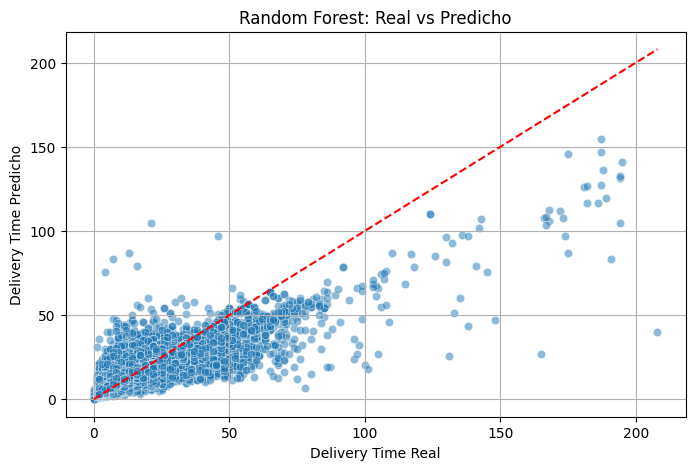

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_multi, y_multi)

# Predecir
y_pred_rf = rf_model.predict(X_multi)

# Métricas
print("Regresión con Random Forest")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_rf), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_rf)), 2))
print("R²:", round(r2_score(y_multi, y_pred_rf), 4))

# Gráfico Real vs Predicho
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_rf, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Random Forest: Real vs Predicho")
plt.grid(True)
plt.show()


Con Random Forest, el modelo también muestra un buen desempeño, aunque ligeramente inferior al Árbol de Decisión. El R cuadrado es de 0.7671, lo que indica que explica aproximadamente el 77% de la variabilidad en el tiempo de entrega. Visualmente, el ajuste es bueno, pero se observa una mayor dispersión alrededor de la línea roja. El MAE (2.59) y el RMSE (4.51) son mayores que en el Árbol de Decisión, pero siguen siendo razonables. Esto sugiere que Random Forest maneja bien los datos, pero no logra capturar algunas de las complejidades mejor que un solo árbol profundo.

### Support Vector Regression (SVR)

Regresión con SVR (muestra de 5000 registros)
MAE: 5.9
RMSE: 8.97
R²: -0.0495


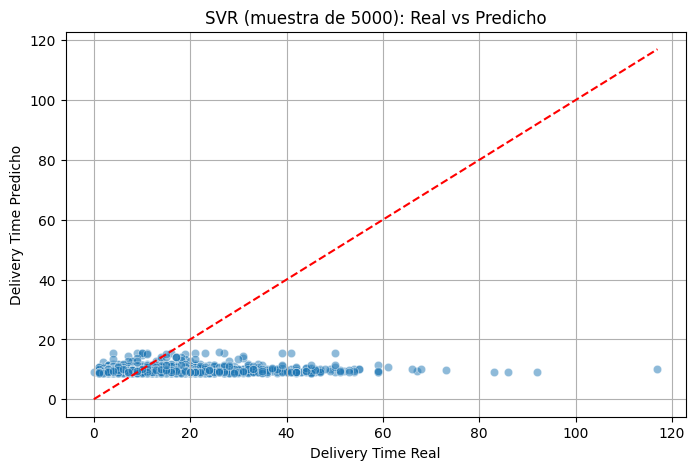

In [19]:
# ==================== FLUJO COMPLETO PARA SVR ====================

# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Cargar el dataset
# Cambia el path si es necesario dependiendo dónde esté tu archivo
df_model = pd.read_csv('olist_dataset_modelado.csv')

# 3. Definir X_multi e y_multi
X_multi = df_model[['price', 'freight_value', 'product_weight_g',
                    'product_length_cm', 'product_height_cm',
                    'product_width_cm', 'product_category_encoded']]

y_multi = df_model['delivery_time']

# 4. Crear muestra para SVR
X_svr_sample = X_multi.sample(5000, random_state=42)
y_svr_sample = y_multi.loc[X_svr_sample.index]

# 5. Entrenar modelo SVR
svr_model = SVR(kernel='rbf')
svr_model.fit(X_svr_sample, y_svr_sample)

# 6. Predicción
y_pred_svr = svr_model.predict(X_svr_sample)

# 7. Métricas
print("Regresión con SVR (muestra de 5000 registros)")
print("MAE:", round(mean_absolute_error(y_svr_sample, y_pred_svr), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_svr_sample, y_pred_svr)), 2))
print("R²:", round(r2_score(y_svr_sample, y_pred_svr), 4))

# 8. Gráfico Real vs Predicho
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_svr_sample, y=y_pred_svr, alpha=0.5)
plt.plot([y_svr_sample.min(), y_svr_sample.max()], [y_svr_sample.min(), y_svr_sample.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("SVR (muestra de 5000): Real vs Predicho")
plt.grid(True)
plt.show()


El modelo SVR, aplicado sobre una muestra de 5000 datos, muestra resultados pobres. Visualmente, los puntos predichos se agrupan cerca de valores bajos de tiempo de entrega, sin seguir la tendencia real de los datos. El R cuadrado obtenido es negativo (-0.0495), lo que indica que el modelo es incluso peor que simplemente predecir el promedio de los datos. Tanto el MAE (5.9) como el RMSE (8.97) son relativamente altos en comparación con los otros modelos. Esto confirma que SVR no es un modelo adecuado para predecir el tiempo de entrega en este conjunto de datos, probablemente debido a su sensibilidad a conjuntos de datos grandes y no lineales.

## Pipeline

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Cargar el dataset correcto
df_model = pd.read_csv('olist_dataset_modelado.csv')

# Revisar columnas disponibles
df_model.head()

# Variables predictoras y variable objetivo
X = df_model[['price', 'freight_value', 'product_weight_g',
              'product_length_cm', 'product_height_cm',
              'product_width_cm', 'product_category_encoded']]
y = df_model['delivery_time']

# División entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirmar tamaños de los datos
print("Shape de X_train:", X_train_scaled.shape)
print("Shape de X_test:", X_test_scaled.shape)


Shape de X_train: (86782, 7)
Shape de X_test: (21696, 7)


## Metricas

In [21]:
# MÉTRICAS FINALES PARA LOS 6 MODELOS

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear lista para guardar resultados
resultados = []

# Regresión Lineal Simple
mae_simple = mean_absolute_error(y_simple, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_simple, y_pred_simple))
r2_simple = r2_score(y_simple, y_pred_simple)

resultados.append({
    'Modelo': 'Regresión Lineal Simple',
    'MAE': round(mae_simple, 2),
    'RMSE': round(rmse_simple, 2),
    'R²': round(r2_simple, 4)
})

# Regresión Lineal Múltiple
mae_multi = mean_absolute_error(y_multi, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_multi, y_pred_multi))
r2_multi = r2_score(y_multi, y_pred_multi)

resultados.append({
    'Modelo': 'Regresión Lineal Múltiple',
    'MAE': round(mae_multi, 2),
    'RMSE': round(rmse_multi, 2),
    'R²': round(r2_multi, 4)
})

# Regresión Polinomial
mae_poly = mean_absolute_error(y_poly, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_poly, y_pred_poly))
r2_poly = r2_score(y_poly, y_pred_poly)

resultados.append({
    'Modelo': 'Regresión Polinomial (Grado 2)',
    'MAE': round(mae_poly, 2),
    'RMSE': round(rmse_poly, 2),
    'R²': round(r2_poly, 4)
})

# Árbol de Decisión
mae_dt = mean_absolute_error(y_multi, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_multi, y_pred_dt))
r2_dt = r2_score(y_multi, y_pred_dt)

resultados.append({
    'Modelo': 'Árbol de Decisión',
    'MAE': round(mae_dt, 2),
    'RMSE': round(rmse_dt, 2),
    'R²': round(r2_dt, 4)
})

# Random Forest
mae_rf = mean_absolute_error(y_multi, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_multi, y_pred_rf))
r2_rf = r2_score(y_multi, y_pred_rf)

resultados.append({
    'Modelo': 'Random Forest',
    'MAE': round(mae_rf, 2),
    'RMSE': round(rmse_rf, 2),
    'R²': round(r2_rf, 4)
})

# SVR (muestra 5000)
mae_svr = mean_absolute_error(y_svr_sample, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_svr_sample, y_pred_svr))
r2_svr = r2_score(y_svr_sample, y_pred_svr)

resultados.append({
    'Modelo': 'SVR (muestra 5000)',
    'MAE': round(mae_svr, 2),
    'RMSE': round(rmse_svr, 2),
    'R²': round(r2_svr, 4)
})

# Mostrar todo en tabla
df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,MAE,RMSE,R²
0,Regresión Lineal Simple,6.09,9.13,0.0464
1,Regresión Lineal Múltiple,6.05,9.11,0.0515
2,Regresión Polinomial (Grado 2),6.29,9.32,0.0057
3,Árbol de Decisión,1.46,3.81,0.8344
4,Random Forest,2.59,4.51,0.7671
5,SVR (muestra 5000),5.90,8.97,-0.0495


## Semana 3

### Implementación de Modelos de Clasificación

Logistic Regression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Cargar el DataFrame
df = pd.read_csv('olist_dataset_modelado.csv')

# Revisar columnas categóricas y numéricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop('review_score', axis=1).columns.tolist()

# Separar X y y
X = df.drop('review_score', axis=1)
y = df['review_score']

# Pipeline: OneHot para categóricas + Escalado para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Crear pipeline completo (preprocesamiento + modelo)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar
clf.fit(X_train, y_train)

# Predecir
y_pred = clf.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 1973     5   472     0     0]
 [  290   241   205     0     0]
 [  767     3  1065     0     0]
 [    0     0     0   648  3531]
 [    0     0     0    20 12476]]
              precision    recall  f1-score   support

         1.0       0.65      0.81      0.72      2450
         2.0       0.97      0.33      0.49       736
         3.0       0.61      0.58      0.60      1835
         4.0       0.97      0.16      0.27      4179
         5.0       0.78      1.00      0.88     12496

    accuracy                           0.76     21696
   macro avg       0.80      0.57      0.59     21696
weighted avg       0.79      0.76      0.70     21696

